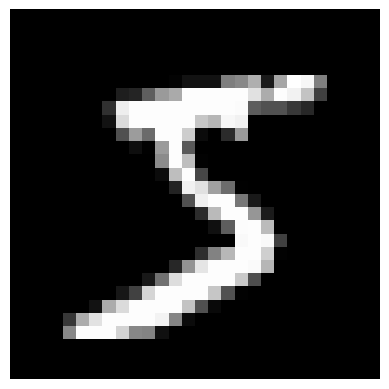

In [5]:
import keras
import numpy as np
import matplotlib.pyplot as plt

(X, Y), (_, _) = keras.datasets.mnist.load_data()
X_b = np.where(X < 64, 0, 1)
plt.imshow(X[0], cmap="gray")
plt.axis("off")
plt.savefig("mnist.png", bbox_inches="tight", pad_inches=0.1, dpi=300)

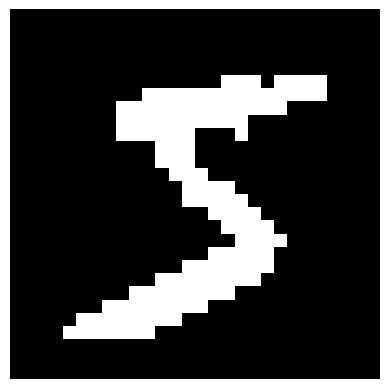

In [6]:
plt.imshow(X_b[0], cmap="gray")
plt.axis("off")
plt.savefig("mnist_binary.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
plt.show()

In [7]:
import torch
import torch.nn as nn

class TimeEmbeddedConvBlock(nn.Module):
    """
    「畳み込み + tの注入 + 正規化 + 活性化」を行う基本ブロック
    """
    def __init__(self, in_channels, out_channels, time_emb_dim, groups=8):
        super().__init__()

        # 空間サイズを維持するための畳み込み (padding=1, kernel_size=3)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        # 時間埋め込みを加工して注入するための全結合層
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)

        # 正規化と活性化
        self.norm = nn.GroupNorm(groups, out_channels)
        self.act = nn.SiLU()

    def forward(self, x, t_emb):
        """
        Args:
            x (Tensor): 画像の特徴マップ (Batch, In_Channels, H, W)
            t_emb (Tensor): 加工済みの時間/パラメータ埋め込み (Batch, time_emb_dim)
        """
        # 1. 畳み込み
        h = self.conv(x)

        # 2. t の情報を加工して加算
        t_proj = self.time_mlp(t_emb)
        # t_proj を (B, C) -> (B, C, 1, 1) に変形して加算できるようにする
        h = h + t_proj.unsqueeze(-1).unsqueeze(-1)

        # 3. 正規化と活性化
        h = self.norm(h)
        h = self.act(h)

        return h

class SimpleTimeNN(nn.Module):
    """
    y = NN(x, t) を表現するネットワーク。
    Conv層を3つ重ね、各層で t の情報を注入する。
    """
    def __init__(self, img_channels=3, t_dim=64, model_channels=64):
        super().__init__()

        # パラメータ t を加工するための MLP
        # t_dim次元のtを受け取り、内部表現の次元 (model_channels * 4) に変換
        time_emb_dim = model_channels * 4
        self.time_mlp = nn.Sequential(
            nn.Linear(t_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        # 最初の畳み込み層
        self.initial_conv = nn.Conv2d(img_channels, model_channels, kernel_size=1)

        # 畳み込みブロックを3つ重ねる
        self.conv_blocks = nn.Sequential(
            TimeEmbeddedConvBlock(model_channels, model_channels, time_emb_dim),
            TimeEmbeddedConvBlock(model_channels, model_channels, time_emb_dim),
            TimeEmbeddedConvBlock(model_channels, model_channels, time_emb_dim)
        )

        # 最後の畳み込み層 (チャンネル数を元の画像のチャンネル数に戻す)
        self.final_conv = nn.Conv2d(model_channels, img_channels, kernel_size=1)

    def forward(self, x, t):
        """
        Args:
            x (Tensor): 入力テンソル (Batch, Channels, H, W)
            t (Tensor): m次元のパラメータ (Batch, t_dim)
        """
        # 1. パラメータ t を加工して埋め込み表現 t_emb を得る
        t_emb = self.time_mlp(t)

        # 2. 初期畳み込み
        h = self.initial_conv(x)

        # 3. 3つのブロックを順に適用
        #    各ブロックに加工済みの t_emb を渡す
        for block in self.conv_blocks:
            h = block(h, t_emb)

        # 4. 最終畳み込みで出力テンソルの形を x と同じにする
        y = self.final_conv(h)

        return y

# === 使用例 ===
if __name__ == '__main__':
    # --- パラメータ設定 ---
    batch_size = 4
    image_size = 32
    img_channels = 3  # RGB画像
    t_dimension = 64  # パラメータtの次元数m

    # --- モデルのインスタンス化 ---
    model = SimpleTimeNN(
        img_channels=img_channels,
        t_dim=t_dimension,
        model_channels=128 # ネットワーク内部のチャンネル数
    )

    # --- ダミーデータの作成 ---
    # x: (B, C, H, W) の画像テンソル
    x = torch.randn(batch_size, img_channels, image_size, image_size)
    # t: (B, m) のパラメータベクトル
    t = torch.randn(batch_size, t_dimension)

    # --- 順伝播の実行 ---
    y = model(x, t)

    # --- 結果の確認 ---
    print(f"入力 x のShape: {x.shape}")
    print(f"パラメータ t のShape: {t.shape}")
    print(f"出力 y のShape: {y.shape}")

    # xとyのShapeが同じであることを確認
    assert x.shape == y.shape
    print("\n✅ 成功: 出力 y は入力 x と同じShapeになりました。")

入力 x のShape: torch.Size([4, 3, 32, 32])
パラメータ t のShape: torch.Size([4, 64])
出力 y のShape: torch.Size([4, 3, 32, 32])

✅ 成功: 出力 y は入力 x と同じShapeになりました。
